# Defining a final DataSet

## Goal:
Recreate the final_dataset.ipynb

## Context:
Recreate the final_dataset, but each student will be considered as n-students where n is the number of semesters coursed. As an example, consider the student with ID 42. This student has been in the university for six semesters.
We will consider student 42 as six students: Student 42 from 1st semester, student 42 from 2nd semester, student 42 from 3rd semester, ... and student 42 from 6th semester.

This will allow the model to capture the behaviour of both dropout and non-dropout students in the early stages of their academic lives.
 

### Academic background
- **colegio**
- **puntaje icfes**
- **edad ingreso**
- **icfes puntaje especifico**
- **especialidad colegio icfes**
- **carrera matriculada**
- **Facultad**
- **genero**

### Academic performance
- **semestres cursados a la fecha** DONE
- **promedio academico a la fecha** DONE
- **promedio ultimo semestre**
- **Materias perdidas** DONE
- **Creditos cursados** DONE

All the features regarding academic performance will be affected by this approach!

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from datetime import datetime
import math
pd.set_option("display.max_columns", None)

We will start from two known files:
1. complete_student_performance
2. gpas_raw

These two files were originated from the final_dataset notebook. The first one has info for every subject that each student has coursed. The second one contains the GPAs for all students for each semester in a tidy format.

In [2]:
# Select the files
complete_student_performance_file = '../../data/processed/complete_student_performance.csv'
gpas_raw = '../../data/processed/gpas_raw.csv'

gpas_raw_df = pd.read_csv(gpas_raw, index_col=0).reset_index()
student_performance = pd.read_csv(complete_student_performance_file, index_col=0)

The following function is already known from other notebooks and helps convert columns data types.

We will use this function to adjust the columns data types for the student_performance DataFrame:

In [3]:
def change_type(df, cols, as_type):
    ''' 
    Takes a DataFrame and a list of columns and transform those columns to the selected format.
              
        Parameters
        ----------
        df: pandas.core.frame.DataFrame
            A pandas DataFrame where the columns will be converted into the desired format.
            
        cols: list
            A list with the name of the columns that will be converted into the desired format.
            
        as_type: {'str', 'float', 'int'}
            A list with the name of the columns that will be converted into the desired format.
            
        Returns
        -------
        dataframe: pandas.core.frame.DataFrame
            A DataFrame with the selected columsn converted into the desired format.
    ''' 
    if (as_type == 'str') or (as_type == 'int'):
        for col in cols:
            try:
                df[col] = df[col].astype(as_type)
            except: pass
        return df
    else:
        for col in cols:
            try:
                df[col] = df[col].str.replace(',','.')
                df[col] = df[col].astype('float64')
            except: pass
        return df

In [4]:
cat_cols = ['PERIODO_COHORTE', 'PERIODO_ACADEMICO', 'CODIGO', 'COD_MAT']
num_cols = ['NOTA_DEF']

student_performance = change_type(student_performance, cat_cols, 'str')
student_performance = change_type(student_performance, num_cols, 'float')


Let's create a new column boolean for the student_performance DataFrame that indicates whether a subject was or was not failed. Then, we can group that DataFrame by student's ID and period, adding the values of the new column:

In [39]:
student_performance['failed_flag'] = [True if i < 3 else False for i in student_performance['NOTA_DEF']]
failed_subjects_df = student_performance.groupby(['CODIGO','PERIODO_ACADEMICO'])[['failed_flag']].sum().reset_index()

Let's now create a copy of the same dataset but now the failed_flag column will be cumulative for each student:

In [40]:
def get_cumulative_failed(df):
    df['cumulative_failed'] = 0
    
    init_cumulative = 0
    codigo = 'sw'
    for index, row in df.iterrows():
        if codigo != df.loc[index, 'CODIGO']:
            codigo = df.loc[index, 'CODIGO']
            init_cumulative = 0
            
            df.loc[index, 'cumulative_failed'] = init_cumulative + df.loc[index, 'failed_flag']
            init_cumulative = df.loc[index, 'cumulative_failed']
        else:
            df.loc[index, 'cumulative_failed'] = init_cumulative + row['failed_flag'] 
            init_cumulative = df.loc[index, 'cumulative_failed']
            
    return df

failed_subjects_df = get_cumulative_failed(failed_subjects_df)
failed_subjects_df.head()

,CODIGO,PERIODO_ACADEMICO,failed_flag,cumulative_failed
0,11312001,201210,0.0,0.0
1,11312001,201220,0.0,0.0
2,11312001,201310,0.0,0.0
3,11312001,201320,0.0,0.0
4,11312001,201410,1.0,1.0


Let's do a similar process with a dataset stored in **'../../data/processed/gpas_grouped_by_student.csv'**. It's like the previous one but this one contains data about number of credits and GPAs per semester. Here we will try to get the cumulative number of credits coursed and the cumulative GPA over the semesters:

In [44]:
grouped_df = pd.read_csv('../../data/processed/gpas_grouped_by_student.csv', index_col=0)

def get_cumulative_credits(df):
    df['cumulative_credits'] = 0
    df['cumulative_gpa'] = 0
    
    init_cumulative = 0
    init_gpa = 0
    codigo = 'sw'
    
    for index, row in df.iterrows():
        if codigo != df.loc[index, 'CODIGO']:
            codigo = df.loc[index, 'CODIGO']
            init_cumulative = 0
            init_gpa = 0
            
            df.loc[index, 'cumulative_credits'] = init_cumulative + df.loc[index, 'NUM_CREDITOS']
            df.loc[index, 'cumulative_gpa'] = init_gpa + df.loc[index, 'GPA']
            
            init_cumulative = df.loc[index, 'cumulative_credits']
            init_gpa = df.loc[index, 'cumulative_gpa']
            
        else:
            df.loc[index, 'cumulative_credits'] = init_cumulative + row['NUM_CREDITOS']
            df.loc[index, 'cumulative_gpa'] = init_gpa + row['GPA']
            
            
            init_cumulative = df.loc[index, 'cumulative_credits']
            init_gpa = df.loc[index, 'cumulative_gpa']
            
    df['real_cumulative_gpa'] = df['cumulative_gpa']/df['cumulative_credits']
            
    return df

num_credits_df = get_cumulative_credits(grouped_df)

In [47]:
num_credits_df.head(5)

,CODIGO,PERIODO_ACADEMICO,NUM_CREDITOS,GPA,real_GPA,cumulative_credits,cumulative_gpa,real_cumulative_gpa
0,11312001,201210,15.0,53.7,3.58,15.0,53.7,3.580000
1,11312001,201220,12.0,47.7,3.98,27.0,101.4,3.755556
2,11312001,201310,10.0,34.8,3.48,37.0,136.2,3.681081
3,11312001,201320,16.0,56.4,3.53,53.0,192.6,3.633962
4,11312001,201410,14.0,46.1,3.29,67.0,238.7,3.562687


These dataframes will serve us for a later merge on our tidy dataset. So let's leave them here for now.
We can now focus on a new dataset called extended_gpas_raw.

This extended_gpas_raw dataset was generated by the **expand_gpas** notebook and represented each student as n different students where n is the number of semesters coursed as stated in the context.

**IMPORTANT**
1. The details of how this dataset was constructed are in the same notebook.
2. Most of the commented markdowns are the same as the final_dataset notebook since the processes are the same.

In [110]:
extended_gpas_raw = pd.read_csv('../../data/processed/extended_gpas_raw.xlsx', index_col = 0)
extended_gpas_raw = extended_gpas_raw.dropna(subset = ['currrent_semester'])

**It is not ideal to have one column for each period, but we can still get useful info from this table like the number of semesters and global GPA (we could have gotten this from the table before pivoting but let's do it from here).**

**The steps for achieving this are the following:**

**- Get the number of semesters coursed as the count of semesters where the GPA > 0.0**
- Calculate the credits coursed with a table called "num_creds"
- Calculate the raw GPA with a table called "gpas_raw"
- Get the real GPA dividing the raw GPA by the gpas_raw
- Get the number of failed subjects**

In [132]:
def get_number_semesters(df):
    df['n_semesters']= 0
    
    for index, row in df.iterrows():
        for column in df.columns[0:-1]:
            if row[column] > 0:
                df.loc[index,'n_semesters'] = df.loc[index,'n_semesters'] + 1
                
    df['n_semesters'] = [i-2 for i in df['n_semesters']]
    try:
        df = df.drop('index', axis = 1)
    except:
        pass
    
    return df

gpas = extended_gpas_raw.reset_index().copy()
gpas_n_semester = get_number_semesters(gpas)

All columns must have the correct data type. let's use our previously defined function again for this: 

In [157]:
gpas_n_semester['currrent_semester'] = gpas_n_semester['currrent_semester'].astype('int')
new_cat_cols = ['currrent_semester', 'CODIGO']

gpas_n_semester = change_type(gpas_n_semester, cat_cols, 'int64')

In [158]:
gpas_n_semester_lite = gpas_n_semester.iloc[:, 35:]

In [167]:
left_table = num_credits_df[["CODIGO", 'PERIODO_ACADEMICO', 'cumulative_credits', 'real_cumulative_gpa']]

gpas_merge_1 = pd.merge(gpas_n_semester_lite, left_table,\
                how="left", left_on = ["CODIGO", 'currrent_semester'], right_on = ["CODIGO", 'PERIODO_ACADEMICO']) 

gpas_merge_1 = gpas_merge_1.drop('currrent_semester', axis = 1)

In [180]:
left_table_2 = failed_subjects_df[["CODIGO", 'PERIODO_ACADEMICO', 'cumulative_failed']]
left_table_2 = change_type(left_table, list(left_table.columns), 'int64')

gpas_merge_2 = pd.merge(gpas_merge_1, left_table_2,\
                how="left", left_on = ["CODIGO", 'PERIODO_ACADEMICO'], right_on = ["CODIGO", 'PERIODO_ACADEMICO'])

In [182]:
left_table_3 = num_credits_df.copy()
left_table_3 = left_table_3[['CODIGO', 'PERIODO_ACADEMICO', 'real_GPA']]
left_table_3.columns = ['CODIGO', 'PERIODO_ACADEMICO', 'gpa_last_semester']

gpas_merge_3 = pd.merge(gpas_merge_2, left_table_3,\
                how="left", left_on = ['CODIGO', 'PERIODO_ACADEMICO'], right_on = ["CODIGO", 'PERIODO_ACADEMICO'])

In [185]:
gpas_merge_3.head(5)

,CODIGO,n_semesters,PERIODO_ACADEMICO,cumulative_credits,real_cumulative_gpa,cumulative_failed,gpa_last_semester
0,11312001,11,201710,150.0,3.504000,5.0,4.56
1,11312001,10,201620,136.0,3.395588,5.0,2.58
2,11312001,9,201610,123.0,3.481301,4.0,3.63
3,11312001,8,201520,112.0,3.466964,4.0,3.46
4,11312001,7,201510,98.0,3.467347,4.0,2.87


In [189]:
perfil_file = '../../data/raw/perfil_ingreso.csv'
student_profile = pd.read_csv(perfil_file, delimiter=';', encoding='latin-1')
student_profile = change_type(student_profile, ['CODIGO'], 'int')
student_profile = student_profile.drop('PERIODO_COHORTE', axis = 1)

In [190]:
extended_with_profile = pd.merge(gpas_merge_3, student_profile, how="left", left_on = "CODIGO", right_on = "CODIGO")

In [195]:
mean_Age = np.mean(extended_with_profile['EDAD'])
extended_with_profile['EDAD'] = extended_with_profile['EDAD'].fillna(mean_Age)

In [207]:
complete_student_performance_file = '../../data/processed/complete_student_performance.csv'
complete_student_performance = pd.read_csv(complete_student_performance_file, index_col=0 )


cat_cols = ['PERIODO_COHORTE', 'PERIODO_ACADEMICO', 'CODIGO', 'COD_MAT']
num_cols = ['NOTA_DEF']

complete_student_performance = change_type(complete_student_performance, cat_cols, 'str')
complete_student_performance = change_type(complete_student_performance, num_cols, 'float')

complete_student_performance[['FACULTAD','NOMBRE_PROGRAMA']] = \
                    complete_student_performance[['FACULTAD','NOMBRE_PROGRAMA']].fillna('GENERAL')
complete_student_performance[['INTRODUCCION']] = complete_student_performance[['INTRODUCCION']].fillna('NO')
complete_student_performance[['NUM_CREDITOS']] = complete_student_performance[['NUM_CREDITOS']].fillna(2)
complete_student_performance[['COD_DOCENTE']] = complete_student_performance[['COD_DOCENTE']].fillna(-1)




program = complete_student_performance.copy()
program = program[program['INTRODUCCION']=='SI']
program = program.groupby(['CODIGO'])['FACULTAD','NOMBRE_PROGRAMA'].agg(lambda x:x.value_counts().index[0]).reset_index()
program['CODIGO'] = program['CODIGO'].astype('int64')

extended_with_program = pd.merge(extended_with_profile, program, how="left", left_on = "CODIGO", right_on = "CODIGO")
extended_with_program = extended_with_program.dropna()

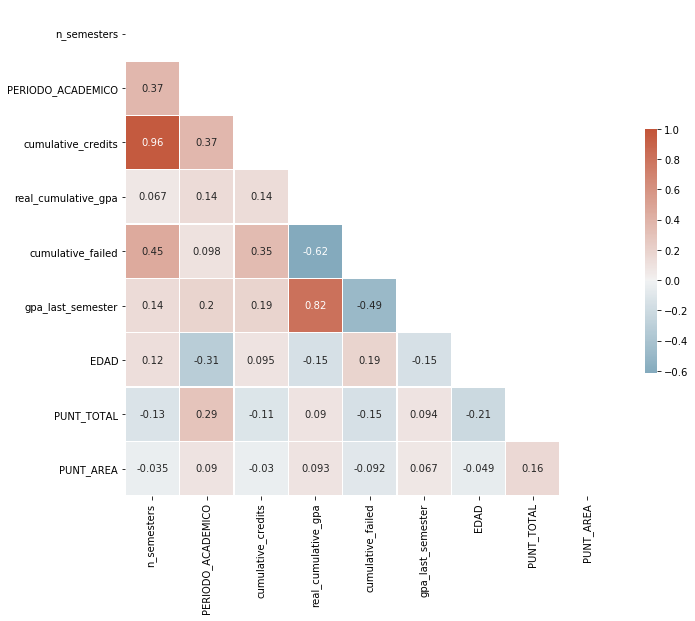

In [210]:
to_drop = ['FACULTAD', 'NOMBRE_PROGRAMA', 'GENERO', 'COLEGIO_PROCEDENCIA', 'ES_DESERTOR', 'CODIGO']
df_correlation = extended_with_program.drop(to_drop, axis = 1).corr()

mask = np.triu(np.ones_like(df_correlation, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_correlation, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [211]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

to_dummies = ['FACULTAD', 'NOMBRE_PROGRAMA', 'GENERO', 'COLEGIO_PROCEDENCIA', 'ES_DESERTOR']

gpas_dummy = pd.get_dummies(extended_with_program.drop(['CODIGO'], axis = 1), drop_first = True)

In [212]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
#Import ROC AUC score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

SEED = 1111
lr = LogisticRegression(random_state = SEED)
knn = KNN(n_neighbors = 6)
dt = DecisionTreeClassifier(criterion = 'gini', random_state = SEED, max_depth = round(len(gpas_dummy)**(1/2)))
rfc = RandomForestClassifier(n_estimators = 500 , min_samples_leaf = 0.12, random_state =SEED)
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=100, random_state=1)
supvm = svm.SVC()

In [213]:
df_desertor = gpas_dummy[gpas_dummy['ES_DESERTOR_SI'] == 1]
df_no_desertor = gpas_dummy[gpas_dummy['ES_DESERTOR_SI'] == 0]

df_no_desertor = df_no_desertor.sample(n=len(df_desertor))

df_new = pd.concat([df_desertor, df_no_desertor])
df_new = df_new.sample(frac=1)

In [214]:
y1 = df_new['ES_DESERTOR_SI'].values
X1 = df_new.drop('ES_DESERTOR_SI', axis = 1).values
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.26, random_state = SEED, stratify = y1)

classifiers =[('Logistic Regression', lr), ('K Nearest Neighbors', knn),\
              ('Classification Tree', dt), ('Random Forest', rfc), ('Ada Boost', ada)]

vc = VotingClassifier(estimators = classifiers)

In [ ]:
for clf_name, clf in classifiers:
    clf.fit(X1_train, y1_train)
    y1_pred = clf.predict(X1_test)
    
    y_pred_proba = clf.predict_proba(X1_test)[:,1]
    roc_score = roc_auc_score(y1_test, y_pred_proba)
    
    print('{:s} accuracy: {:.3f}'.format(clf_name, accuracy_score(y1_test, y1_pred)))
    print('{:s} ROC score: {:.3f}'.format(clf_name, roc_score))
    print('')
    
#vc.fit(X1_train, y1_train)
#supvm.fit(X1_train, y1_train)
#y1_predVC = vc.predict(X1_test)
#y1_predSVM = supvm.predict(X1_test)
#print('Voting Classifier accuracy: {:.3f}'.format(accuracy_score(y1_test, y1_predVC)))
#print('Support Vector Machine accuracy: {:.3f}'.format(accuracy_score(y1_test, y1_predSVM)))

In [ ]:
sns.set()
fig, axes = plt.subplots(2, 3, figsize = (20,12))
idxs = [axes[0,0], axes[0,1], axes[0,2], axes[1,0], axes[1,1]]

for (clf_name, clf), idx in zip(classifiers, idxs):
    #clf.fit(X1_train, y1_train)
    plot_roc_curve(clf, X1_test, y1_test, ax = idx)